In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely import wkt
import os

In [20]:
CITY = 'Knoxville'
COUNTY = 'Knox'

In [21]:
# Load city boundaries and filter for the specific city
tn_city_boundaries = gpd.read_file("zip:///home/rishav/Programs/move_od/data/TN_City_Boundaries.zip")
city_limits = tn_city_boundaries[tn_city_boundaries['NAME'] == CITY]
city_limits = city_limits.to_crs('EPSG:4326')

# Load LODES data
lodes_data = pd.read_csv(f'./generated_OD/{COUNTY}_TN_2021-01-04_2021-01-04/lodes_combs/lodes_2021-01-04.csv')

# Convert 'origin_geom' and 'dest_geom' to geometry
lodes_data['origin_geom'] = lodes_data['origin_geom'].apply(wkt.loads)
lodes_data['dest_geom'] = lodes_data['dest_geom'].apply(wkt.loads)
lodes_data = gpd.GeoDataFrame(lodes_data, geometry='origin_geom', crs='EPSG:4326')

lodes_data = lodes_data.set_crs('EPSG:4326')
# Set 'origin_geom' as active geometry
lodes_data.set_geometry('origin_geom', inplace=True)

# Perform spatial join with city_limits as left df for 'origin_geom'
origin_within_city = gpd.sjoin(city_limits, lodes_data, how="inner", predicate='contains')
origin_indices = set(origin_within_city.index_right)  

# Set 'dest_geom' as active geometry
lodes_data.set_geometry('dest_geom', inplace=True)
lodes_data = lodes_data.set_crs('EPSG:4326')

# Perform spatial join with city_limits as left df for 'dest_geom'
dest_within_city = gpd.sjoin(city_limits, lodes_data, how="inner", predicate='contains')
dest_indices = set(dest_within_city.index_right)  # Get the indices of lodes_data and convert to set

# Find common indices between origin and destination
common_indices = origin_indices.intersection(dest_indices)
common_indices_list = list(common_indices)

# Filter lodes_data for rows where both 'origin_geom' and 'dest_geom' are within the city limits
city_lodes_both = lodes_data.loc[common_indices_list]

<AxesSubplot:>

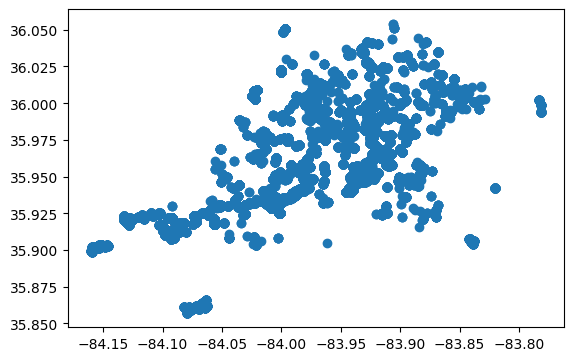

In [22]:
city_lodes_both.plot()

In [14]:
os.makedirs('origin_dest', exist_ok=True)
city_lodes_both.to_csv(f'./origin_dest/{CITY}_origin_dest.csv')

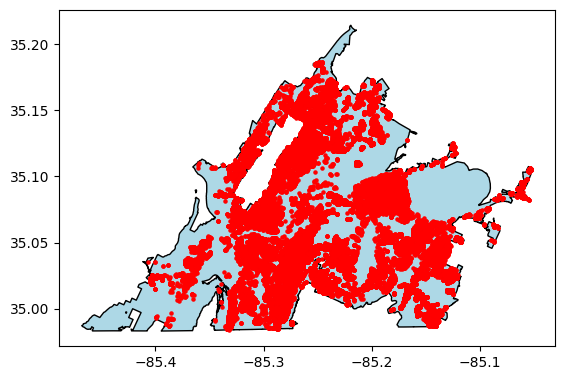

In [11]:
import matplotlib.pyplot as plt

# Plot city_limits
fig, ax = plt.subplots()
city_limits.plot(ax=ax, color='lightblue', edgecolor='black')  # Adjust colors as needed

# Plot od_data geometries on the same axis
city_lodes_both['origin_geom'].plot(ax=ax, marker='o', color='red', markersize=5)  # Adjust marker and color

plt.show()